#SparkWings ✈️

---



In [ ]:
# Install Java
!apt-get install openjdk-11-jdk-headless -qq > /dev/null

# Download Spark from a reliable Apache archive source
!curl -L -o spark-3.4.2-bin-hadoop3.tgz https://archive.apache.org/dist/spark/spark-3.4.2/spark-3.4.2-bin-hadoop3.tgz

# Extract the Spark archive
!tar -xzf spark-3.4.2-bin-hadoop3.tgz

# Install Python packages
!pip install -q findspark pyspark

# Set environment variables
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.4.2-bin-hadoop3"

# Initialize Spark
import findspark
findspark.init()


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  370M  100  370M    0     0  24.6M      0  0:00:15  0:00:15 --:--:-- 26.8M


In [ ]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("FlightPrediction") \
    .getOrCreate()


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/Colab Notebooks/SparkWings/NavV3
!ls

/content/drive/MyDrive/Colab Notebooks/SparkWings/NavV3
flightdata.csv	SparkWingsV3.ipynb


In [ ]:
!cp flightdata.csv /content

In [ ]:
%cd /content
!ls

/content
drive		sample_data		 spark-3.4.2-bin-hadoop3.tgz
flightdata.csv	spark-3.4.2-bin-hadoop3


In [ ]:
# Load the cleaned flight data and aircraft configuration
flight_df = spark.read.csv("flightdata.csv", header=True, inferSchema=True)

In [ ]:
flight_df.show()

+---------+--------+-----+---+----+-----------+------------+-------+-------+-------+----+--------+------+----+----------+-----+----------+-------+-------+-------+---------+----------+----------+--------+--------+--------+-------+-------+-------+-----+
|     date|coded_id|month|day|year|day_of_week|registration|seats_j|seats_w|seats_y|temp|humidity|percip|snow|wind_speed|cloud|visibility|final_j|final_w|final_y|final_tob|total_bags|wheelchair|booked_j|booked_w|booked_y|meals_j|meals_w|meals_y|cargo|
+---------+--------+-----+---+----+-----------+------------+-------+-------+-------+----+--------+------+----+----------+-----+----------+-------+-------+-------+---------+----------+----------+--------+--------+--------+-------+-------+-------+-----+
| 1/1/2012|       1|    1|  1|2012|          1|         BLU|     45|     38|    225|46.2|    78.2|  78.2| 0.0|      25.2| 45.8|       9.8|     45|     38|    223|      306|       323|         3|      31|      35|     228|     45|     38|    225

In [ ]:
from pyspark.sql.functions import col
from pyspark.sql.types import DoubleType, IntegerType

# List all the relevant numeric columns (add/remove based on your use case)
numeric_columns = [
    "coded_id", "month", "day", "year", "day_of_week", "seats_j",
    "seats_w", "seats_y", "temp", "humidity", "percip", "snow", "wind_speed",
    "cloud", "visibility", "final_j", "final_w", "final_y", "final_tob",
    "total_bags", "wheelchair", "booked_j", "booked_w", "booked_y",
    "meals_j", "meals_w", "meals_y", "cargo"
]

# Cast columns to DoubleType (can also use IntegerType where appropriate)
for col_name in numeric_columns:
    flight_df = flight_df.withColumn(col_name, col(col_name).cast(DoubleType()))

In [ ]:
from pyspark.sql.functions import when, col, round as spark_round, monotonically_increasing_id
from pyspark.ml.feature import StringIndexer, VectorAssembler, Imputer, StandardScaler
from pyspark.ml.regression import GBTRegressor
from pyspark.ml import Pipeline

# Define features
feature_cols = ["month", "day", "year", "day_of_week", "seats_j", "seats_w",
                "seats_y", "temp", "humidity", "percip", "snow", "wind_speed",
                "cloud", "visibility", "wheelchair", "booked_j", "booked_w", "booked_y"
]

# Build a pipeline for a given label
def make_pipeline(label_col):
    indexer = StringIndexer(inputCol="registration", outputCol="registrationIndex", handleInvalid="skip")
    imputer = Imputer(inputCols=feature_cols, outputCols=feature_cols)
    assembler = VectorAssembler(
        inputCols=feature_cols + ["registrationIndex"],
        outputCol="features"
    )
    scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=True)
    gbt = GBTRegressor(featuresCol="scaledFeatures", labelCol=label_col, maxIter=100)
    return Pipeline(stages=[indexer, imputer, assembler, scaler, gbt])

# Train-test split
train_data, test_data = flight_df.randomSplit([0.8, 0.2], seed=42)
train_data = train_data.na.drop(subset=["Final_J", "Final_W", "Final_Y"]).cache()
test_data = test_data.na.drop(subset=["Final_J", "Final_W", "Final_Y"]).cache()

In [ ]:
from pyspark.sql.functions import monotonically_increasing_id
from pyspark.ml.evaluation import RegressionEvaluator
from functools import reduce

# 0) add a unique id to test_data for joining later
test_data_id = test_data.withColumn("uid", monotonically_increasing_id()).cache()

labels    = ["final_j", "final_w", "final_y"]
evaluator = RegressionEvaluator(metricName="rmse", labelCol=None, predictionCol="prediction")

results     = {}
preds_dict  = {}

for label in labels:
    # --- 1) build & fit pipeline ---
    pipeline = make_pipeline(label_col=label)
    model    = pipeline.fit(train_data)

    # --- 2) save the fitted pipeline model ---
    model.write().overwrite().save(f"models/pipeline_{label}")

    # --- 3) get preds (including uid, actual, predicted) ---
    preds = (
      model
        .transform(test_data_id)
        .select("uid", label, "prediction")
        .withColumnRenamed(label, f"actual_{label}")
        .withColumnRenamed("prediction", f"pred_{label}")
        .cache()
    )
    preds_dict[label] = preds

    # --- 4) eval metrics ---
    rmse = evaluator.setLabelCol(label).evaluate(preds.withColumnRenamed(f"actual_{label}", label)
                                                     .withColumnRenamed(f"pred_{label}", "prediction"))
    r2   = evaluator.setMetricName("r2").evaluate(preds.withColumnRenamed(f"actual_{label}", label)
                                                    .withColumnRenamed(f"pred_{label}", "prediction"))

    # --- 5) feature importances ---
    gbtModel    = model.stages[-1]
    feats       = feature_cols + ["registrationIndex"]
    importances = list(zip(feats, gbtModel.featureImportances.toArray()))
    importances.sort(key=lambda x: x[1], reverse=True)

    results[label] = {
      "rmse":         rmse,
      "r2":           r2,
      "importances": importances[:10]
    }

# --- 6) print summary metrics & top features ---
for label, m in results.items():
    print(f"=== {label} ===")
    print(f"RMSE = {m['rmse']:.2f}, R² = {m['r2']:.3f}")
    print("Top 10 features:")
    for feat, score in m["importances"]:
        print(f"  {feat:15s} {score:.4f}")
    print()

# --- 7) join all preds on uid into one wide DF ---
all_preds = reduce(
    lambda df1, df2: df1.join(df2, on="uid"),
    [preds_dict[label] for label in labels]
)

# inspect
all_preds.show(5)


=== final_j ===
RMSE = 3.12, R² = 0.897
Top 10 features:
  booked_j        0.5313
  year            0.0502
  month           0.0466
  booked_w        0.0447
  booked_y        0.0410
  temp            0.0376
  seats_j         0.0334
  day             0.0277
  wind_speed      0.0275
  humidity        0.0272

=== final_w ===
RMSE = 0.88, R² = 0.879
Top 10 features:
  booked_w        0.5188
  year            0.0668
  booked_j        0.0540
  booked_y        0.0495
  temp            0.0346
  cloud           0.0342
  day             0.0314
  month           0.0313
  humidity        0.0278
  registrationIndex 0.0246

=== final_y ===
RMSE = 0.93, R² = 0.931
Top 10 features:
  booked_y        0.6777
  booked_j        0.0388
  booked_w        0.0326
  temp            0.0306
  day             0.0298
  cloud           0.0286
  humidity        0.0243
  month           0.0239
  wind_speed      0.0202
  day_of_week     0.0191

+---+--------------+------------------+--------------+-----------------+--

In [ ]:
all_preds.write.mode("overwrite").option("header", True).csv("predictions/all_labels_preds")

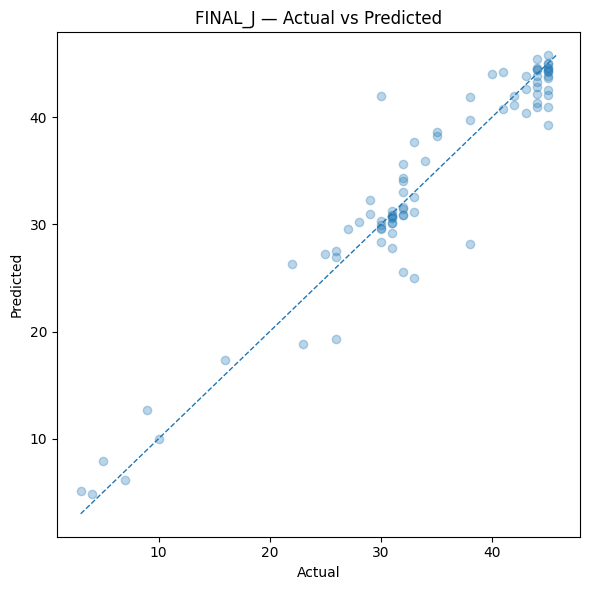

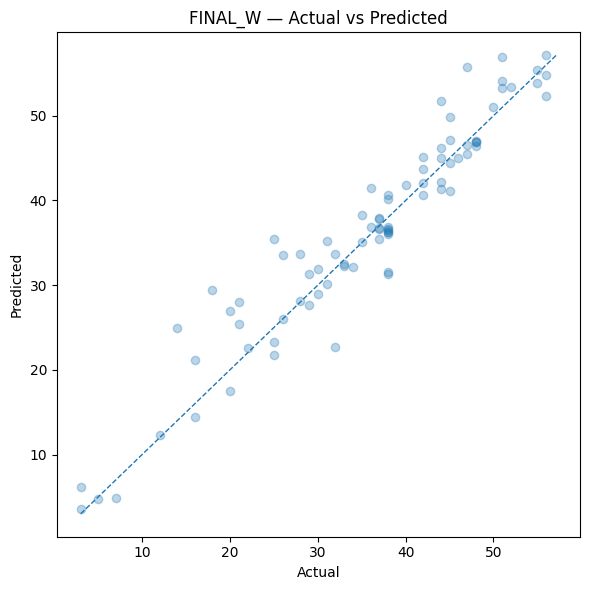

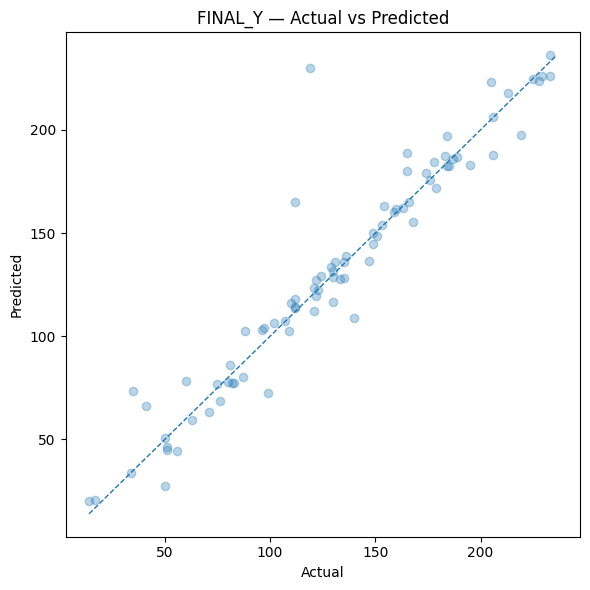

In [ ]:
import matplotlib.pyplot as plt

# first sample & pull into Pandas
pdf = all_preds.sample(False, 0.1, seed=42).toPandas()

for label in ["final_j", "final_w", "final_y"]:
    actual_col = f"actual_{label}"
    pred_col   = f"pred_{label}"

    mn = min(pdf[actual_col].min(), pdf[pred_col].min())
    mx = max(pdf[actual_col].max(), pdf[pred_col].max())

    plt.figure(figsize=(6,6))
    plt.scatter(pdf[actual_col], pdf[pred_col], alpha=0.3)
    plt.plot([mn, mx], [mn, mx], "--", linewidth=1)
    plt.title(f"{label.upper()} — Actual vs Predicted")
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.tight_layout()
    plt.show()


In [ ]:
!cp -r /content/models /content/drive/MyDrive/Colab\ Notebooks/SparkWings/NavV3/models
!cp -r /content/predictions /content/drive/MyDrive/Colab\ Notebooks/SparkWings/NavV3/predictions